<a href="https://colab.research.google.com/github/abhinavdayal/EVA4/blob/master/S14/Segmentation_Based_Data_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![MIT Deep Learning](https://deeplearning.mit.edu/files/images/github/mit_deep_learning.png)

<table align="center">
  <td align="center"><a target="_blank" href="https://deeplearning.mit.edu">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_mit.png" style="height:40px; padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/lexfridman/mit-deep-learning/blob/master/tutorial_driving_scene_segmentation/tutorial_driving_scene_segmentation.ipynb">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_google_colab.png" style="height:40px; padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_driving_scene_segmentation/tutorial_driving_scene_segmentation.ipynb">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_github.png" style="height:40px; padding-bottom:5px;"  />View Source on GitHub</a></td>
  <td align="center"><a target="_blank" href="https://www.youtube.com/playlist?list=PLrAXtmErZgOeiKm4sgNOknGvNjby9efdf">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_youtube.png" style="height:40px; padding-bottom:5px;" />Watch Videos</a></td>
<!--   <td><a target="_blank" href="link">
        <img src="image" />text</a></td> -->
</table>

# MIT Driving Scene Segmentation

This tutorial demostrates the steps to run DeepLab semantic scene segmentation model on a sample video from MIT Driving Scene Segmentation Dataset.

In [0]:
# Tensorflow
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

TensorFlow 1.x selected.
1.15.2


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

### Visualization
Now let's create some helper functions for decoding and visualizing the results.

In [0]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### Load the model from a frozen graph
There are two model checkpoints pre-trained on Cityscapes with different network backbones: MobileNetV2 and Xception65. We default to use MobileNetV2 for faster inference.

In [0]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


### Run on the sample image
The sample image is frame #0 in the MIT Driving Scene Segmentation (DriveSeg) Dataset.

running deeplab on the sample image...


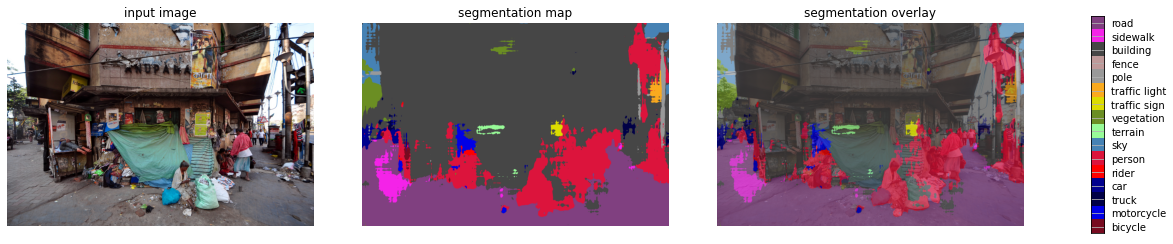

In [0]:
SAMPLE_IMAGE = '/content/drive/My Drive/S15A/background/images/image064.jpg'
if not os.path.isfile(SAMPLE_IMAGE):
    print('downloading the sample image...')
    SAMPLE_IMAGE = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.png?raw=true')[0]
print('running deeplab on the sample image...')

def run_visualization(SAMPLE_IMAGE):
    """Inferences DeepLab model and visualizes result."""
    original_im = Image.open(SAMPLE_IMAGE)
    seg_map = MODEL.run(original_im)
    vis_segmentation(original_im, seg_map)

run_visualization(SAMPLE_IMAGE)

## Depth Image

In [0]:
!git clone https://github.com/nianticlabs/monodepth2.git

Cloning into 'monodepth2'...
remote: Enumerating objects: 138, done.
remote: Total 138 (delta 0), reused 0 (delta 0), pack-reused 138
Receiving objects: 100% (138/138), 10.25 MiB | 12.49 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [0]:
!python monodepth2/test_simple.py --image_path '/content/drive/My Drive/S15A/foreground/image001.png' --model_name mono+stereo_640x192

-> Downloading pretrained model to models/mono+stereo_640x192.zip
   Unzipping model...
   Model unzipped to models/mono+stereo_640x192
-> Loading model from  models/mono+stereo_640x192
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to /content/drive/My Drive/S15A/foreground/image001_disp.jpeg
-> Done!


# Data Generation

In [0]:
# find a random location to put the cow image
from random import seed
import random
# seed random number generator

In [0]:
def fgdim(d, skylimit, y, maxscale=0.9, minscale=0.2):
  maxdim = int(d*maxscale)
  mindim = int(d*minscale)
  return max(mindim, int((1-(d-y+1)/(d-skylimit+1))*maxdim))

Below code is to reduce the ground region so as to avoid very small patches of ground to act as base to place the foreground

In [0]:
# def area(a, x, y, limit, cur):
#   if cur > limit:
#     return
#   a[x][y]=2
#   cur += 1
#   if a[x-1][y]==1:
#     cur = area(a, x-1, y, limit, cur)
#   if a[x+1][y]==1:
#     cur = area(a, x+1, y, limit, cur)
#   if a[x][y-1]==1:
#     cur = area(a, x, y-1, limit, cur)
#   if a[x][y+1]==1:
#     cur = area(a, x, y+1, limit, cur)
#   return cur

def processrow(a, r, limit):
  h, w = a.shape
  i = 0
  while i<w:
    while i<w and a[r][i]==0:
      i+=1
    j = i
    while i<w and a[r][i]>0:
      i+=1
    if i-j < limit:
      while j<i:
        a[r][j] = 0
        j += 1

def processcol(a, c, limit):
  h, w = a.shape
  i = 0
  while i<h:
    while i<h and a[i][c]==0:
      i+=1
    j = i
    while i<h and a[i][c]>0:
      i+=1
    if i-j < limit:
      while j<i:
        a[j][c] = 0
        j += 1

def boundaryreduce(a, limit=5):
  h,w = a.shape
  for i in range(h):
    processrow(a, i, limit)
  for i in range(w):
    processcol(a, i, limit)


Below is an attempt to place an object behind some foreground object. However this is very errorprone. 

In [0]:
# update the mask to allow for occlusions
# idea here would be probably to keep all segments that are non vegetation/ground
# and start from before the bottom of the cow, probably come in front of cow.
# this may not work in many cases but this is just an iniital try
def updatemask(mask, segments, x, y):
  h, w = segments.shape
  i = h-1
  for j in range(w):
    k = i
    while k>=0 and segments[k][j] not in [0, 1, 9, 10, 8]:
      if mask.shape[0] > k and mask.shape[1] > j:
        mask[k][j] = 0  
      k -= 1

## Helper methods

### random crop and flip


In [0]:
import math
import os
from tqdm.notebook import tqdm
def randomflip(im):
  r = random.random()
  if r>0.5:
    return im.transpose(Image.FLIP_LEFT_RIGHT), True
  return im, False

# crops image and its segment to given size and possibly flips is horizontally
def random_crop_n_flip(img, segment, depth, newsize=(250, 250)):
  img, f = randomflip(img)
  
  w, h = img.size
  if h>w:
    left, right = 0, w
    bottom, top = h, h-w
  else:
    left = int(random.random()*(w-h))
    right = left+h
    bottom, top = h, 0
  cropped = img.crop((left, top, right, bottom))  # size: 45, 45

  dep = depth.transpose(Image.FLIP_LEFT_RIGHT) if f else depth
  dep = dep.crop((left, top, right, bottom))

  cs = np.flip(segment, 1) if f else segment
  cs = cs[top:bottom, left:right]
  
  #return cropped.resize(newsize), cs, dep
  return cropped, cs, dep

### Location selection to place foreground object
We want to place foreground object on ground plane randomly. Below functions will first extract the potential ground pixels and then pick one at random as center of the foreground object

In [0]:

def show_binary_image(img):
  display(Image.fromarray((img*255).astype(np.uint8), mode='L'))

def extract_ground(segment, skylimit):
  # get all rows having road, sidewalk or terrain below the sky
  g = ((segment==0) | (segment==1) | (segment==9))*1
  # process g such that small patches and ground above skylimit are removed.
  g[:skylimit, :] = 0
  boundaryreduce(g, 10)
  #show_binary_image(g)
  return g

def pick_random_center(cs, skylimit):
  g = extract_ground(cs, skylimit) # rows having road, sidewalk or terrain below the sky
  groundrows = list(filter(lambda x: x>=skylimit, (np.where((g).sum(axis=1)>0)[0])))
  if len(groundrows)==0:
    py = skylimit + int(random.random()*(cs.shape[0]-skylimit))
    px = int(random.random()*cs.shape[1])
  else:
    py = random.choice(groundrows) # random row that has ground groundrows[0]
    px = random.choice(np.where(g[py])[0]) # random ground pixel in that row
  return px, py

### Scale selection
Next we want to determine how big the foreground should be. We try to apply perspective foreshortening. Since we do not know the camera parameters and what we are looking at, we depend on manually provided scales. 

A scale range is from bottom to skylimit of image how the foreground should scale, i.e. relative to background width how many pixels wide should the foreground be and how that width should change as one moves up the background image

In [0]:
def scaled_foreground(fg, newsize, cdict, py, skylimit):
  fh, fw = fg.height, fg.width
  
  e = math.sqrt(np.sum((np.array(fg)[:, :, 3]<200))/(fh*fw))

  r = cdict[1] + ((py-skylimit+1)/(newsize[0]-skylimit+1))*(cdict[0]-cdict[1])
  r *= e
  print(cdict[0], cdict[1], r, e)
  csize = (newsize[0]*r, newsize[1]*r)
  ar = csize[0]*csize[1]
  dw = int(math.sqrt(ar)*fw/fh)
  dh = int(dw*(fh/fw))
  fg = fg.resize((dw, dh))

  mask = np.array(fg)[:, :, 3]
  mask[mask<200]=0
  #updatemask(mask, cs[py:py+dw, px:px+dw], px+dw, py+dh)
  mask = Image.fromarray(mask, mode='L')

  return fg, mask

def place(bg, fg, mask, px, py):
  #print("top, left of placing image : ", py, px, "skylimit = ", skylimit, ", r = ", r)
  fh, fw = fg.height, fg.width
  py -= fh//2
  px -= fw//2
  #print("height, width of fg image: ", fh, fw)
  bg.paste(fg, (px, py), mask)
  #cropped.crop((0, int(newsize[1]*0.5), newsize[0], newsize[1])).save("temp.jpg")
  #cropped.save("temp.jpg")
  fmask = Image.new('1', bg.size)
  fmask.paste(mask, (px, py))

  return bg, fmask

### Prepare folders for output

There will be output folder containing images, masks and depths

In [0]:
def prepfolders(outpath):
  impath = os.path.join(outpath, "images")
  maskpath = os.path.join(outpath, "masks")
  depthpath = os.path.join(outpath, "depths")
  if not os.path.exists(outpath):
    os.mkdir(outpath)
  if not os.path.exists(impath):
    os.mkdir(impath)
  if not os.path.exists(maskpath):  
    os.mkdir(maskpath)
  if not os.path.exists(depthpath):  
    os.mkdir(depthpath)

  return impath, maskpath, depthpath

### Main Methods
These methods take in the input folders and produce the outputs.

In [0]:
gcount = 0

def prepare(bgimg, fgimg, depthimg, segimg, impath, maskpath, segpath, depthpath, cdict, newsize=(250,250), multiplier=20):
  global gcount
  print(bgimg, fgimg, end=' ')

  original_im = Image.open(bgimg)
  depth_im = Image.open(depthimg)
  s = np.load(segimg)
  h, w = s.shape

  # find the last row that has sky in it
  skylimit = max(int((np.argmax(np.sum((s==10), axis=1)==0))*newsize[1]/original_im.height), 125)
  #print(bgimg, "skylimit: ", skylimit)

  fgim = Image.open(fgimg)
  
  for _ in range(multiplier):
    cropped, cs, dep = random_crop_n_flip(original_im, s, depth_im, newsize)
    px, py = pick_random_center(cs, skylimit)
    fg, _ = randomflip(fgim)
    fg, mask = scaled_foreground(fg, newsize, cdict, py, skylimit)
    finalimg, finalmask = place(cropped, fg, mask, px, py)
    gcount += 1
    #print("saving", gcount)
    #finalimg = finalimg.resize((224, 224))
    finalimg.save(os.path.join(impath, f"image{gcount:0>3d}.jpg"))
    finalmask = finalmask.resize((224, 224))
    finalmask.save(os.path.join(maskpath, f"mask{gcount:0>3d}.jpg"))
    dep = dep.resize((224, 224))
    dep.save(os.path.join(depthpath, f"depth{gcount:0>3d}.jpg"))
    #if gcount%10==0:
    #  print(f"generated {gcount} images")   

In [0]:
def generatesegments(bgpath, segpath):
  print("generating segmentation images")
  for bg in tqdm(os.listdir(bgpath)): 
    if not bg.endswith('.jpg'):
      continue
    bgimg = os.path.join(bgpath, bg)
    original_im = Image.open(bgimg)
    seg_map = MODEL.run(original_im)
    seg_image = Image.fromarray(label_to_color_image(seg_map).astype(np.uint8), mode='RGB')
    seg_image.save(os.path.join(segpath, f"seg_{bg}"))
    np.save(os.path.join(segpath, f"seg_{bg}.npy"), seg_map)

In [0]:
def createdata(inpath, outpath, resultcount):
  global gcount
  gcount = 0
  impath, maskpath, depthpath = prepfolders(outpath)
  cfg = open(os.path.join(inpath, "bg/data.txt"))
  cdict = {}
  for line in cfg.readlines():
    name, s1, s2 = line.split()
    cdict[name]=(float(s1), float(s2))
  cfg.close()

  bgpath = os.path.join(inpath, "bg/images")
  fgpath = os.path.join(inpath, "cyclist")
  depath = os.path.join(inpath, "bg/depths")
  segpath = os.path.join(inpath, "bg/segments")

  if not os.path.exists(segpath):
    os.mkdir(segpath)
    generatesegments(bgpath, segpath)

  bglist = list(filter(lambda x: x.endswith('jpg'), os.listdir(bgpath)))
  fglist = list(filter(lambda x: x.endswith('png'), os.listdir(fgpath)))

  for i in tqdm(range(resultcount)): 
    bg = random.choice(bglist)
    fg = random.choice(fglist)
    bgimg = os.path.join(bgpath, bg)
    depimg = os.path.join(depath, f"depth{bg}")
    segimg = os.path.join(segpath, f"seg_{bg}.npy")
    fgimg = os.path.join(fgpath, fg)
    prepare(bgimg, fgimg, depimg, segimg, impath, maskpath, segpath, depthpath, cdict[bg], newsize=(448,448), multiplier=20)

In [0]:
createdata('/content/drive/My Drive/S15A/', '/content/drive/My Drive/S15A/output5/', 100)

/content/drive/My Drive/S15A/bg/images/image065.jpg /content/drive/My Drive/S15A/cyclist/image1.png 0.75 0.2 0.6092065636348314 0.8303017052005771
0.75 0.2 0.3928911193852073 0.8303017052005771
0.75 0.2 0.5986912295393635 0.8303017052005771
0.75 0.2 0.3973976911404078 0.8303017052005771
0.75 0.2 0.5956868483692299 0.8303017052005771
0.75 0.2 0.5506211308172249 0.8303017052005771
0.75 0.2 0.46800064863854907 0.8303017052005771
0.75 0.2 0.5265860814561556 0.8303017052005771
0.75 0.2 0.6197218977302992 0.8303017052005771
0.75 0.2 0.5070576038502866 0.8303017052005771
0.75 0.2 0.6152153259750986 0.8303017052005771
0.75 0.2 0.6152153259750986 0.8303017052005771
0.75 0.2 0.5551277025724254 0.8303017052005771
0.75 0.2 0.4454677898625465 0.8303017052005771
0.75 0.2 0.5956868483692299 0.8303017052005771
0.75 0.2 0.5010488415100193 0.8303017052005771
0.75 0.2 0.4905335074145515 0.8303017052005771
0.75 0.2 0.56714522725296 0.8303017052005771
0.75 0.2 0.5821671331036284 0.8303017052005771
0.75 0.2

KeyboardInterrupt: ignored

In [0]:
def getsize(img):
  w, h = img.width, img.height
  if w>h:
    w = int(250*(w/h))
    h = 250
  else:
    h = int(250*(h/w))
    w = 250
  return w,h

In [0]:
# resize all input bg and fg images to max 250 height and do the same for segments and weights along with .npy files
bgpath = '/content/drive/My Drive/S15A/original/images'
for bg in tqdm(os.listdir(bgpath)):
  if bg.endswith('jpg') or bg.endswith('jpeg'):
    img = Image.open(os.path.join(bgpath, bg))
    w, h = getsize(img)
    img = img.resize((w,h))
    img.save(os.path.join(bgpath, bg))
  elif bg.endswith(npy):
    s = np.load(os.path.join(bgpath, bg))
    img = Image.fromarray((s*10).astype(np.uint8), mode='L')
    w, h = getsize(img)
    img = img.resize((w,h))
    s = np.array(img)//10
    np.save(os.path.join(bgpath, bg), s)

In [0]:
s = np.load('/content/drive/My Drive/S15A/original/images/image001_disp.npy')

In [0]:
s.shape

(1, 1, 192, 640)

In [0]:
s

array([[[[0.14646967, 0.14564109, 0.144794  , ..., 0.13929594,
          0.13949026, 0.13966866],
         [0.14676964, 0.14580534, 0.14499058, ..., 0.13961272,
          0.1397534 , 0.13999154],
         [0.14731917, 0.14625075, 0.14552832, ..., 0.13972756,
          0.13995592, 0.14011897],
         ...,
         [0.9682205 , 0.96619105, 0.96885306, ..., 0.7839898 ,
          0.7864847 , 0.7896865 ],
         [0.97030216, 0.96786666, 0.97192675, ..., 0.79031897,
          0.79206353, 0.7955671 ],
         [0.9737336 , 0.97139287, 0.974447  , ..., 0.79329675,
          0.79496056, 0.7983027 ]]]], dtype=float32)

In [0]:
img = Image.open('/content/drive/My Drive/S15A/original/images/image001.jpg')

In [0]:
img.size

(4504, 2275)